In [15]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import butter, filtfilt

In [16]:
import numpy as np
from scipy.signal import butter, filtfilt

def lowpass_filter_data(data, cutoff=4, fs=100, order=4):
    """
    Apply a Butterworth lowpass filter to the data along each column.

    Parameters:
      data   : 2D NumPy array of shape (n, 5)
      cutoff : Cutoff frequency in Hz (default is 4 Hz)
      fs     : Original sampling frequency (default is 100 Hz)
      order  : Order of the Butterworth filter (default is 4)
    
    Returns:
      Filtered data as a NumPy array with the same shape as the input.
    """
    nyq = 0.5 * fs                  # Nyquist Frequency
    normal_cutoff = cutoff / nyq    # Normalized cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Use filtfilt to avoid phase shift.
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def downsample(data, orig_rate=100, new_rate=10):
    """
    Downsample the data from orig_rate to new_rate by taking every (orig_rate/new_rate)-th sample.
    
    Parameters:
      data      : 2D NumPy array of shape (n, 5)
      orig_rate : Original sampling frequency (Hz)
      new_rate  : Desired sampling frequency (Hz)
    
    Returns:
      Downsampled data.
    """
    factor = orig_rate // new_rate
    return data[::factor]

def find_near_zero_blocks(data, tol=1e-2, min_gap=30):
    """
    Identify the start indices of contiguous blocks where all 5 columns are near zero.
    A new near-zero block is only accepted if it is at least 'min_gap' samples after the previous one.

    Parameters:
      data    : 2D NumPy array of shape (n, 5)
      tol     : Tolerance to consider a value as zero (default is 1e-2)
      min_gap : Minimum number of samples between consecutive near-zero blocks (default is 30)
    
    Returns:
      A NumPy array of filtered start indices for near-zero blocks.
    """
    # Create a boolean mask that is True when all 5 columns are nearly zero.
    near_zero = np.all(np.abs(data[:,:4]) < tol, axis=0)
    
    # Compute differences to identify transitions from non-zero to near-zero.
    diff = np.diff(near_zero.astype(int))
    starts = np.where(near_zero == True)[0]   # +1 to point to the first True value in the block
    
    # If the very first sample is near zero, include index 0.
    if near_zero[0]:
        starts = np.insert(starts, 0, 0)
    
    # Filter out indices that are too close together.
    filtered_starts = []
    if len(starts) > 0:
        filtered_starts.append(starts[0])
        for idx in starts[1:]:
            if idx - filtered_starts[-1] >= min_gap:
                filtered_starts.append(idx)
    
    return np.array(filtered_starts)

def find_cycle_boundaries(data, tol=1e-2, min_gap=30):
    """
    Identify cycle boundaries in the periodic data. Here, a cycle is assumed to start at the first 
    near-zero block and end at the start of the next near-zero block that is at least 'min_gap' samples later.
    
    Parameters:
      data    : 2D NumPy array (downsampled) of shape (n, 5)
      tol     : Tolerance to consider a value as zero (default is 1e-2)
      min_gap : Minimum number of samples between consecutive near-zero blocks (default is 30)
    
    Returns:
      A tuple (cycle_start, cycle_stop) indicating the start and stop indices of one cycle.
    """
    near_zero_starts = find_near_zero_blocks(data, tol, min_gap)
    
    if len(near_zero_starts) < 2:
        raise ValueError("Not enough near-zero regions found to determine a cycle!")
    
    cycle_start = near_zero_starts[0]
    cycle_stop = near_zero_starts[1]
    return cycle_start, cycle_stop


In [40]:
# def lowpass_filter(data, cutoff=5, fs=100, order=4):
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     y = filtfilt(b, a, data, axis=0)
#     return y

def extract_gait_cycle(c, gait_duration=3):

    times = c["parameters"]["EVENT"]["TIMES"]['value']
    contexts = c["parameters"]["EVENT"]["CONTEXTS"]['value']
    labels = c["parameters"]["EVENT"]["LABELS"]['value']
    gait_points = []

    for i in range(len(labels)):
        if (labels[i] == "Foot Strike1") and (contexts[i] == "Right"):
            gait_start = int(times[1,i]*100)
        if (labels[i] == "Foot Strike2") and (contexts[i] == "Right"):
            gait_end = int(times[1,i]*100)

    trial_data = c['data']['points']
    labels = c['parameters']['POINT']['LABELS']['value']

    #[15,4,16,5,20,9]
    r_ftc = labels.index("R_FTC") if "R_FTC" in labels else RuntimeError("R_FTC not found")
    l_ftc = labels.index("L_FTC") if "L_FTC" in labels else RuntimeError("L_FTC not found")
    r_fle = labels.index("R_FLE") if "R_FLE" in labels else RuntimeError("R_FLE not found")
    l_fle = labels.index("L_FLE") if "L_FLE" in labels else RuntimeError("L_FLE not found")
    r_fal = labels.index("R_FAL") if "R_FAL" in labels else RuntimeError("R_FAL not found")
    l_fal = labels.index("L_FAL") if "L_FAL" in labels else RuntimeError("L_FAL not found")
    r_fcc = labels.index("R_FCC") if "R_FCC" in labels else RuntimeError("R_FCC not found")
    r_fm1 = labels.index("R_FM1") if "R_FM1" in labels else RuntimeError("R_FM1 not found")
    l_fcc = labels.index("L_FCC") if "L_FCC" in labels else RuntimeError("L_FCC not found")
    l_fm1 = labels.index("L_FM1") if "L_FM1" in labels else RuntimeError("L_FM1 not found")

    sjn = labels.index("SJN") if "SJN" in labels else RuntimeError("SJN not found")
    sxs = labels.index("SXS") if "SXS" in labels else RuntimeError("SXS not found")

    r_leglength_ind = c['parameters']['SUBJECT']['LABELS']['value'].index("R_legLength") if "R_legLength" in c['parameters']['SUBJECT']['LABELS']['value'] else RuntimeError("R_LEGLENGTH not found")
    l_leglength_ind = c['parameters']['SUBJECT']['LABELS']['value'].index("L_legLength") if "L_legLength" in c['parameters']['SUBJECT']['LABELS']['value'] else RuntimeError("L_LEGLENGTH not found")
    weight = c['parameters']['SUBJECT']['LABELS']['value'].index("weight") if "weight" in c['parameters']['SUBJECT']['LABELS']['value'] else RuntimeError("Weight not found")
    height = c['parameters']['SUBJECT']['LABELS']['value'].index("height") if "height" in c['parameters']['SUBJECT']['LABELS']['value'] else RuntimeError("Height not found")
    r_leglength = c['parameters']['SUBJECT']['VALUES']['value'][r_leglength_ind]
    l_leglength = c['parameters']['SUBJECT']['VALUES']['value'][l_leglength_ind]
    weight = c['parameters']['SUBJECT']['VALUES']['value'][weight]
    height = c['parameters']['SUBJECT']['VALUES']['value'][height]

    muscle_index = [r_ftc,l_ftc,r_fle,l_fle,r_fal,l_fal,sxs,sjn,r_fcc,r_fm1,l_fcc,l_fm1]
    joint_data = trial_data[:,muscle_index,:]
    joint_states = np.zeros((joint_data.shape[2],4))

    data_len = joint_data.shape[2]

    first_pos = trial_data[0,sxs,0]
    last_pos = trial_data[0,sxs,-1]

    if last_pos > first_pos:
        forward_walk = True
    else:
        forward_walk = False

    speed_muscle = trial_data[:,sxs,:]
    speed = (np.abs(speed_muscle[0,-1]-speed_muscle[0,0])/(len(speed_muscle[0,:])))/10
    #data_point[:,-1] = speed

    if forward_walk:
        for i in range(data_len):
            joint_states[i,0] = np.arctan2((joint_data[0,2,i] - joint_data[0,0,i])   , (-joint_data[2,2,i] + joint_data[2,0,i])) 
            joint_states[i,1] = np.arctan2((joint_data[0,4,i] - joint_data[0,2,i])   , (-joint_data[2,4,i] + joint_data[2,2,i]))  - joint_states[i,0]
            joint_states[i,2] = np.arctan2((joint_data[0,3,i] - joint_data[0,1,i])   , (-joint_data[2,3,i] + joint_data[2,1,i]))
            joint_states[i,3] = np.arctan2((joint_data[0,5,i] - joint_data[0,3,i])   , (-joint_data[2,5,i] + joint_data[2,3,i]))  - joint_states[i,2]
            # joint_states[i,4] = np.arctan2((joint_data[2,9,i] - joint_data[2,8,i])   , (joint_data[0,9,i] - joint_data[0,8,i]))   - joint_states[i,0] - joint_states[i,1]
            # joint_states[i,5] = np.arctan2((joint_data[2,11,i] - joint_data[2,10,i]) , (joint_data[0,11,i] - joint_data[0,10,i])) - joint_states[i,2] - joint_states[i,3]
            # joint_states[i,4] = speed
            # joint_states[i,5] = r_leglength
            # joint_states[i,6] = l_leglength
    else:
        for i in range(data_len):
            joint_states[i,0] = np.arctan2((-joint_data[0,2,i] + joint_data[0,0,i]) , (-joint_data[2,2,i] + joint_data[2,0,i])) 
            joint_states[i,1] = np.arctan2((-joint_data[0,4,i] + joint_data[0,2,i]) , (-joint_data[2,4,i] + joint_data[2,2,i])) - joint_states[i,0]
            joint_states[i,2] = np.arctan2((-joint_data[0,3,i] + joint_data[0,1,i]) , (-joint_data[2,3,i] + joint_data[2,1,i]))
            joint_states[i,3] = np.arctan2((-joint_data[0,5,i] + joint_data[0,3,i]) , (-joint_data[2,5,i] + joint_data[2,3,i])) - joint_states[i,2]
            # joint_states[i,4] = np.arctan2((joint_data[2,9,i] - joint_data[2,8,i])   ,(-joint_data[0,9,i] + joint_data[0,8,i]))   - joint_states[i,0] - joint_states[i,1]
            # joint_states[i,5] = np.arctan2((joint_data[2,11,i] - joint_data[2,10,i]) ,(-joint_data[0,11,i] + joint_data[0,10,i])) - joint_states[i,2] - joint_states[i,3]
            # joint_states[i,4] = speed
            # joint_states[i,5] = r_leglength
            # joint_states[i,6] = l_leglength
    total_gait_sample = 32
    joint_states = lowpass_filter_data(joint_states)
    # gait_start, gait_end = find_cycle_boundaries(joint_states, tol=1e-1, min_gap=30)
    joint_states = joint_states[gait_start:gait_end,:]
    joint_states = downsample(joint_states, orig_rate=100, new_rate=10)
    if joint_states.shape[0] > total_gait_sample:
        print(f'gait cycle: {joint_states.shape[1]} longer than {gait_duration} seconds')
        
    while joint_states.shape[0] < total_gait_sample:
        joint_states = np.concatenate((joint_states, joint_states),axis=0)  # Stack horizontally

    joint_states = joint_states[:total_gait_sample,:]
    # padded_joint_states = np.zeros((512, 4))
    # padded_joint_states[46:46+joint_states.shape[0],:] = joint_states
    
    joint_states_rfft = np.fft.rfft(joint_states, n=32,axis=0)
    real_fft = np.real(joint_states_rfft)
    imag_fft = np.imag(joint_states_rfft)
    joint_states_rfft = np.stack((real_fft, imag_fft), axis=2)
    freq_values = np.fft.rfftfreq(32, 1/10)
    encoder_vec = np.empty((3))   # init_pos + speed + r_leglength + l_leglength + ramp_angle = 0
    # encoder_vec[0:4] = joint_states[:,0]
    encoder_vec[0] = speed/3
    encoder_vec[1] = r_leglength /1.5
    encoder_vec[2] = l_leglength /1.5
    # encoder_vec[3] = weight / 100  # 100 is the maximum weight in the dataset
    # encoder_vec[4] = height / 2    # 1.91 m is the maximum height in the dataset

    encoder_vec = encoder_vec[np.newaxis, :]
    joint_states_rfft = joint_states_rfft[np.newaxis, :, :] #179 is the maximum value in the dataset
    return joint_states_rfft, freq_values, encoder_vec, joint_states

In [41]:
import os
gait_duration = 2
folders = [d for d in os.listdir(os.path.join(os.getcwd(),'dataset')) if os.path.isdir(os.path.join(os.path.join(os.getcwd(),'dataset'), d))]
k=0
if os.path.exists(f"gait reference fft_plots_") == False:
    os.mkdir(f"gait reference fft_plots_")

for folder in folders:
    folder_len = len(folder)
    files = [f for f in os.listdir(os.path.join(os.getcwd(),'dataset',folder)) if f.endswith('.c3d')]
    
    print(f"{k}/{len(folders)} is processed current folder is {folder}") 
    i = 0
    for file in files:
        if 'ST' not in file:
            c = c3d(os.path.join('dataset',folder,file))
            joint_states_rfft, freq_values, encoder_vec, joint_states = extract_gait_cycle(c,gait_duration=gait_duration)
            # if np.max(np.abs(joint_states)) > 1:
            #     print(f'joint_states max value is greater than 1 in {folder}_{file[:-4]}')
            #     break
            if i == 0:
                folder_output_state = joint_states_rfft
                folder_input_vector = encoder_vec
            else:
                folder_output_state = np.vstack((folder_output_state,joint_states_rfft))
                folder_input_vector = np.vstack((folder_input_vector,encoder_vec))
            i+=1
    print('folder_output_state_shape: ',folder_output_state.shape)
    print('folder input vector shape: ',folder_input_vector.shape)
    print('-----------------------------------')
    if k == 0:
        total_output_state = folder_output_state
        total_input_vector = folder_input_vector
    else:
        total_output_state = np.vstack((total_output_state,folder_output_state))
        total_input_vector = np.vstack((total_input_vector,folder_input_vector))
    k+=1
#     np.save(f"ref_gait_library_duration{gait_duration}/{folder}_output_state.npy",folder_output_state)
#     np.save(f"ref_gait_library_duration{gait_duration}/{folder}_input_vector.npy",folder_input_vector)

if os.path.exists(f"gait reference fft{freq_values[-1]:.2f}") == False:
    os.mkdir(f"gait reference fft{freq_values[-1]:.2f}")

np.save(f"gait reference fft{freq_values[-1]:.2f}/output_fft_constants.npy",total_output_state)
np.save(f"gait reference fft{freq_values[-1]:.2f}/input_vector.npy",total_input_vector)

print('total output state ',total_output_state.shape)
print('total input vector ',total_input_vector.shape)

0/50 is processed current folder is 2014016
folder_output_state_shape:  (20, 17, 4, 2)
folder input vector shape:  (20, 3)
-----------------------------------
1/50 is processed current folder is 2014005
gait cycle: 4 longer than 2 seconds
gait cycle: 4 longer than 2 seconds
gait cycle: 4 longer than 2 seconds
folder_output_state_shape:  (24, 17, 4, 2)
folder input vector shape:  (24, 3)
-----------------------------------
2/50 is processed current folder is 2014022
folder_output_state_shape:  (22, 17, 4, 2)
folder input vector shape:  (22, 3)
-----------------------------------
3/50 is processed current folder is 2014015
folder_output_state_shape:  (24, 17, 4, 2)
folder input vector shape:  (24, 3)
-----------------------------------
4/50 is processed current folder is 2014025
folder_output_state_shape:  (23, 17, 4, 2)
folder input vector shape:  (23, 3)
-----------------------------------
5/50 is processed current folder is 2015032
folder_output_state_shape:  (21, 17, 4, 2)
folder inp

**New Normalization**

In [42]:
print(np.max(np.abs(total_input_vector[:,0])))  # speed
print(np.max(np.abs(total_input_vector[:,1])))  # r_leglength
print(np.max(np.abs(total_input_vector[:,2])))  # l_leglength

print(total_output_state.shape)                 #shape of the vector

r1_coeff = np.max(np.abs(total_output_state[:,0,:,0]))
i1_coeff = np.max(np.abs(total_output_state[:,0,:,1]))
r2_coeff = np.max(np.abs(total_output_state[:,1,:,0]))
i2_coeff = np.max(np.abs(total_output_state[:,1,:,1]))
r3_coeff = np.max(np.abs(total_output_state[:,2,:,0]))
i3_coeff = np.max(np.abs(total_output_state[:,2,:,1]))
r4_coeff = np.max(np.abs(total_output_state[:,3,:,0]))
i4_coeff = np.max(np.abs(total_output_state[:,3,:,1]))
r5_coeff = np.max(np.abs(total_output_state[:,4,:,0]))
i5_coeff = np.max(np.abs(total_output_state[:,4,:,1]))
r6_coeff = np.max(np.abs(total_output_state[:,5,:,0]))
i6_coeff = np.max(np.abs(total_output_state[:,5,:,1]))
r7_coeff = np.max(np.abs(total_output_state[:,6,:,0]))
i7_coeff = np.max(np.abs(total_output_state[:,6,:,1]))
r8_coeff = np.max(np.abs(total_output_state[:,7,:,0]))
i8_coeff = np.max(np.abs(total_output_state[:,7,:,1]))
r9_coeff = np.max(np.abs(total_output_state[:,8,:,0]))
i9_coeff = np.max(np.abs(total_output_state[:,8,:,1]))
r10_coeff = np.max(np.abs(total_output_state[:,9,:,0]))
i10_coeff = np.max(np.abs(total_output_state[:,9,:,1]))
r11_coeff = np.max(np.abs(total_output_state[:,10,:,0]))
i11_coeff = np.max(np.abs(total_output_state[:,10,:,1]))
r12_coeff = np.max(np.abs(total_output_state[:,11,:,0]))
i12_coeff = np.max(np.abs(total_output_state[:,11,:,1]))
r13_coeff = np.max(np.abs(total_output_state[:,12,:,0]))
i13_coeff = np.max(np.abs(total_output_state[:,12,:,1]))
r14_coeff = np.max(np.abs(total_output_state[:,13,:,0]))
i14_coeff = np.max(np.abs(total_output_state[:,13,:,1]))
r15_coeff = np.max(np.abs(total_output_state[:,14,:,0]))
i15_coeff = np.max(np.abs(total_output_state[:,14,:,1]))
r16_coeff = np.max(np.abs(total_output_state[:,15,:,0]))
i16_coeff = np.max(np.abs(total_output_state[:,15,:,1]))
r17_coeff = np.max(np.abs(total_output_state[:,16,:,0]))
i17_coeff = np.max(np.abs(total_output_state[:,16,:,1]))

print(f'r1_coeff: {r1_coeff} i1_coeff: {i1_coeff}')
print(f'r2_coeff: {r2_coeff} i2_coeff: {i2_coeff}')
print(f'r3_coeff: {r3_coeff} i3_coeff: {i3_coeff}')
print(f'r4_coeff: {r4_coeff} i4_coeff: {i4_coeff}')
print(f'r5_coeff: {r5_coeff} i5_coeff: {i5_coeff}')
print(f'r6_coeff: {r6_coeff} i6_coeff: {i6_coeff}')
print(f'r7_coeff: {r7_coeff} i7_coeff: {i7_coeff}')
print(f'r8_coeff: {r8_coeff} i8_coeff: {i8_coeff}')
print(f'r9_coeff: {r9_coeff} i9_coeff: {i9_coeff}')
print(f'r10_coeff: {r10_coeff} i10_coeff: {i10_coeff}')
print(f'r11_coeff: {r11_coeff} i11_coeff: {i11_coeff}')
print(f'r12_coeff: {r12_coeff} i12_coeff: {i12_coeff}')
print(f'r13_coeff: {r13_coeff} i13_coeff: {i13_coeff}')
print(f'r14_coeff: {r14_coeff} i14_coeff: {i14_coeff}')
print(f'r15_coeff: {r15_coeff} i15_coeff: {i15_coeff}')
print(f'r16_coeff: {r16_coeff} i16_coeff: {i16_coeff}')
print(f'r17_coeff: {r17_coeff} i17_coeff: {i17_coeff}')

total_output_state[:,0,:,0] = total_output_state[:,0,:,0]/r1_coeff
total_output_state[:,0,:,1] = total_output_state[:,0,:,1]
total_output_state[:,1,:,0] = total_output_state[:,1,:,0]/r2_coeff
total_output_state[:,1,:,1] = total_output_state[:,1,:,1]/i2_coeff
total_output_state[:,2,:,0] = total_output_state[:,2,:,0]/r3_coeff
total_output_state[:,2,:,1] = total_output_state[:,2,:,1]/i3_coeff
total_output_state[:,3,:,0] = total_output_state[:,3,:,0]/r4_coeff
total_output_state[:,3,:,1] = total_output_state[:,3,:,1]/i4_coeff
total_output_state[:,4,:,0] = total_output_state[:,4,:,0]/r5_coeff
total_output_state[:,4,:,1] = total_output_state[:,4,:,1]/i5_coeff
total_output_state[:,5,:,0] = total_output_state[:,5,:,0]/r6_coeff
total_output_state[:,5,:,1] = total_output_state[:,5,:,1]/i6_coeff
total_output_state[:,6,:,0] = total_output_state[:,6,:,0]/r7_coeff
total_output_state[:,6,:,1] = total_output_state[:,6,:,1]/i7_coeff
total_output_state[:,7,:,0] = total_output_state[:,7,:,0]/r8_coeff
total_output_state[:,7,:,1] = total_output_state[:,7,:,1]/i8_coeff
total_output_state[:,8,:,0] = total_output_state[:,8,:,0]/r9_coeff
total_output_state[:,8,:,1] = total_output_state[:,8,:,1]/i9_coeff
total_output_state[:,9,:,0] = total_output_state[:,9,:,0]/r10_coeff
total_output_state[:,9,:,1] = total_output_state[:,9,:,1]/i10_coeff
total_output_state[:,10,:,0] = total_output_state[:,10,:,0]/r11_coeff
total_output_state[:,10,:,1] = total_output_state[:,10,:,1]/i11_coeff
total_output_state[:,11,:,0] = total_output_state[:,11,:,0]/r12_coeff
total_output_state[:,11,:,1] = total_output_state[:,11,:,1]/i12_coeff
total_output_state[:,12,:,0] = total_output_state[:,12,:,0]/r13_coeff
total_output_state[:,12,:,1] = total_output_state[:,12,:,1]/i13_coeff
total_output_state[:,13,:,0] = total_output_state[:,13,:,0]/r14_coeff
total_output_state[:,13,:,1] = total_output_state[:,13,:,1]/i14_coeff
total_output_state[:,14,:,0] = total_output_state[:,14,:,0]/r15_coeff
total_output_state[:,14,:,1] = total_output_state[:,14,:,1]/i15_coeff
total_output_state[:,15,:,0] = total_output_state[:,15,:,0]/r16_coeff
total_output_state[:,15,:,1] = total_output_state[:,15,:,1]/i16_coeff
total_output_state[:,16,:,0] = total_output_state[:,16,:,0]/r17_coeff
total_output_state[:,16,:,1] = total_output_state[:,16,:,1]


#i1 and i17 is zero for all the data points
normalizationconst = [r1_coeff,i1_coeff,r2_coeff,i2_coeff,r3_coeff,i3_coeff,r4_coeff,i4_coeff,r5_coeff,i5_coeff,r6_coeff,i6_coeff,r7_coeff,i7_coeff,r8_coeff,i8_coeff,r9_coeff,i9_coeff,r10_coeff,i10_coeff,r11_coeff,i11_coeff,r12_coeff,i12_coeff,r13_coeff,i13_coeff,r14_coeff,i14_coeff,r15_coeff,i15_coeff,r16_coeff,i16_coeff,r17_coeff,i17_coeff]

np.save(f"gait reference fft{freq_values[-1]:.2f}/newnormalized_output_fft_constants.npy",total_output_state)
np.save(f"gait reference fft{freq_values[-1]:.2f}/newnormalized_input_vector.npy",total_input_vector)
np.save(f"gait reference fft{freq_values[-1]:.2f}/newnormalization_constants.npy",normalizationconst)


0.7792810314909367
0.6131200393040975
0.610983689626058
(1143, 17, 4, 2)
r1_coeff: 18.640146475485608 i1_coeff: 0.0
r2_coeff: 4.647393410432269 i2_coeff: 7.339284362006474
r3_coeff: 5.650498095270567 i3_coeff: 7.42038311036306
r4_coeff: 7.691350763941512 i4_coeff: 8.400825516755768
r5_coeff: 7.9291576998954385 i5_coeff: 5.750448885972114
r6_coeff: 5.147585541309002 i6_coeff: 4.927635942191211
r7_coeff: 5.537468776260772 i7_coeff: 4.350563119374307
r8_coeff: 4.673475883443481 i8_coeff: 5.455495743322678
r9_coeff: 4.208688019569827 i9_coeff: 5.481883956717162
r10_coeff: 1.7809764927468497 i10_coeff: 1.8288584139096575
r11_coeff: 1.3685216315022963 i11_coeff: 1.6905349591461332
r12_coeff: 1.5025137863566582 i12_coeff: 1.366551160973413
r13_coeff: 0.7816124090047333 i13_coeff: 1.2790148780907262
r14_coeff: 0.832538895034308 i14_coeff: 0.7966805331779563
r15_coeff: 0.5969407968659162 i15_coeff: 0.3399243784148428
r16_coeff: 0.5659848552269097 i16_coeff: 0.35234033954450983
r17_coeff: 1.3641

**Old Way of Normalization**

In [29]:
# NORMALIZATION OF THE DATA IS IMPLEMENTED
import numpy as np
real_rthigh = np.max(np.abs(total_output_state[:,:,0,0]))
imag_rthigh = np.max(np.abs(total_output_state[:,:,0,1]))

real_rshank = np.max(np.abs(total_output_state[:,:,1,0]))
imag_rshank = np.max(np.abs(total_output_state[:,:,1,1]))

real_lthigh = np.max(np.abs(total_output_state[:,:,2,0]))
imag_lthigh = np.max(np.abs(total_output_state[:,:,2,1]))

real_lshank = np.max(np.abs(total_output_state[:,:,3,0]))
imag_lshank = np.max(np.abs(total_output_state[:,:,3,1]))

print(real_rthigh,imag_rthigh,real_rshank,imag_rshank,real_lthigh,imag_lthigh,real_lshank,imag_lshank)

normalizationconst = np.array([real_rthigh,imag_rthigh,real_rshank,imag_rshank,real_lthigh,imag_lthigh,real_lshank,imag_lshank])

total_output_state[:,:,0,0] = total_output_state[:,:,0,0] / real_rthigh
total_output_state[:,:,1,0] = total_output_state[:,:,1,0] / real_rshank
total_output_state[:,:,2,0] = total_output_state[:,:,2,0] / real_lthigh
total_output_state[:,:,3,0] = total_output_state[:,:,3,0] / real_lshank

total_output_state[:,:,0,1] = total_output_state[:,:,0,1] / imag_rthigh
total_output_state[:,:,1,1] = total_output_state[:,:,1,1] / imag_rshank
total_output_state[:,:,2,1] = total_output_state[:,:,2,1] / imag_lthigh
total_output_state[:,:,3,1] = total_output_state[:,:,3,1] / imag_lshank

np.save(f"gait reference fft{freq_values[-1]:.2f}/oldnormalized_output_fft_constants.npy",total_output_state)
np.save(f"gait reference fft{freq_values[-1]:.2f}/oldnormalized_input_vector.npy",total_input_vector)
np.save(f"gait reference fft{freq_values[-1]:.2f}/oldnormalization_constants.npy",normalizationconst)

7.901030205290768 5.521259817435723 18.456033746012857 8.203208839185772 7.9291576998954385 6.00687035498604 18.640146475485608 8.400825516755768


In [ ]:
# def create_ifft_plots(joint_states_rfft,joint_states,frequencies,path,crop_ind=30):
#     frequency = frequencies[crop_ind]
#     joint_states_rfft = 180*np.squeeze(joint_states_rfft)
#     cropped = joint_states_rfft.copy()
#     cropped[crop_ind:,:] = 0
#     ifft = np.fft.irfft(cropped, axis=0)
#     cropped_ifft = ifft[56:-56,:]
#     fig, axs = plt.subplots(2, 2, figsize=(10, 8))
#     axs[0, 0].plot(joint_states[:,0])
#     axs[0, 0].plot(cropped_ifft[:,0])
#     axs[0, 0].legend(['Original', 'Reconstructed'])
#     axs[0, 0].set_title('Right Shank')
#     axs[0, 1].plot(joint_states[:,1])
#     axs[0, 1].plot(cropped_ifft[:,1])
#     axs[0, 1].set_title('Right Thigh')
#     axs[0, 1].legend(['Original', 'Reconstructed'])
#     axs[1, 0].plot(joint_states[:,2])
#     axs[1, 0].plot(cropped_ifft[:,2])
#     axs[1, 0].set_title('Left Shank')
#     axs[1, 0].legend(['Original', 'Reconstructed'])
#     axs[1, 1].plot(joint_states[:,3])
#     axs[1, 1].plot(cropped_ifft[:,3])
#     axs[1, 1].set_title('Left Thigh')
#     axs[1, 1].legend(['Original', 'Reconstructed'])
#     plt.savefig(path+'.png')
#     plt.close() 

**Training Part**

In [43]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
train_for = "normal"

inputs = np.load(rf"gait reference fft5.00/newnormalized_input_vector.npy")
outputs = np.load(rf"gait reference fft5.00/newnormalized_output_fft_constants.npy")

#train test split using sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=23)

y_train = y_train
y_train  = y_train.transpose(0,2,3,1)
if train_for == "taga":
    y_train = y_train[:,:4,:,:]
print(y_train.shape)
y_train = y_train.reshape(y_train.shape[0],-1)
y_test = y_test
y_test = y_test.transpose(0,2,3,1)
if train_for == "taga":
    y_test = y_test[:,:4,:,:]
print(y_test.shape)
y_test = y_test.reshape(y_test.shape[0],-1)
#convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# create dataloader
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_test, y_test)

print('train data shape: ',X_train.shape)
print('test data shape: ',X_test.shape)
print('train output shape: ',y_train.shape)
print('test output shape: ',y_test.shape)

(914, 4, 2, 17)
(229, 4, 2, 17)
train data shape:  torch.Size([914, 3])
test data shape:  torch.Size([229, 3])
train output shape:  torch.Size([914, 136])
test output shape:  torch.Size([229, 136])


**New Normalize**

In [45]:
def denormalize(pred,gt,normalizationconst):
    #form is [5,2,17]
    for i in range(17):
        for k in range(2):
            pred[:,k,i] = pred[:,k,i] * normalizationconst[i*2+k]
            gt[:,k,i] = gt[:,k,i] * normalizationconst[i*2+k]
    
    return pred,gt

def pred_ifft(predictions,ground_truth,speed,normalizationconst):
    #form is [5,2,17]
    real_pred = predictions[:,0,:]
    imag_pred = predictions[:,1,:]
    predictions = real_pred + 1j*imag_pred
    real_gt = ground_truth[:,0,:]
    imag_gt = ground_truth[:,1,:]
    ground_truth = real_gt + 1j*imag_gt
    

    pred_time = np.fft.irfft(predictions, axis=1)
    gt_time = np.fft.irfft(ground_truth, axis=1)
    pred_time = pred_time.transpose(1,0)
    gt_time = gt_time.transpose(1,0)
    #plot 2*2 subplots
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    plt.plot(pred_time[:,0])
    plt.plot(gt_time[:,0])
    plt.title('Right Hip')
    plt.legend(['Predicted','Ground Truth'])
    plt.subplot(2,2,2)
    plt.plot(pred_time[:,1])
    plt.plot(gt_time[:,1])
    plt.title('Right Knee')
    plt.legend(['Predicted','Ground Truth'])
    plt.subplot(2,2,3)
    plt.plot(pred_time[:,2])
    plt.plot(gt_time[:,2])
    plt.title('Left Hip')
    plt.legend(['Predicted','Ground Truth'])
    plt.subplot(2,2,4)
    plt.plot(pred_time[:,3])
    plt.plot(gt_time[:,3])
    plt.title('Left Knee')
    plt.legend(['Predicted','Ground Truth'])


    plt.savefig(f"compare/new{speed:.2f}ms.png")
    plt.close()
    print('plots saved')
    return pred_time,gt_time

**Old Denormalize**

In [38]:
def denormalize(pred,gt,normalizationconst):
    #form is [5,2,17]
    pred[0,0,:] = pred[0,0,:] * normalizationconst[0]
    pred[0,1,:] = pred[0,1,:] * normalizationconst[1]
    pred[1,0,:] = pred[1,0,:] * normalizationconst[2]
    pred[1,1,:] = pred[1,1,:] * normalizationconst[3]
    pred[2,0,:] = pred[2,0,:] * normalizationconst[4]
    pred[2,1,:] = pred[2,1,:] * normalizationconst[5]
    pred[3,0,:] = pred[3,0,:] * normalizationconst[6]
    pred[3,1,:] = pred[3,1,:] * normalizationconst[7]

    

    gt[0,0,:] = gt[0,0,:] * normalizationconst[0]
    gt[0,1,:] = gt[0,1,:] * normalizationconst[1]
    gt[1,0,:] = gt[1,0,:] * normalizationconst[2]
    gt[1,1,:] = gt[1,1,:] * normalizationconst[3]
    gt[2,0,:] = gt[2,0,:] * normalizationconst[4]
    gt[2,1,:] = gt[2,1,:] * normalizationconst[5]
    gt[3,0,:] = gt[3,0,:] * normalizationconst[6]
    gt[3,1,:] = gt[3,1,:] * normalizationconst[7]

    
    return pred,gt
    

def pred_ifft(predictions,ground_truth,speed,normalizationconst):
    #form is [5,2,17]
    real_pred = predictions[:,0,:]
    imag_pred = predictions[:,1,:]
    predictions = real_pred + 1j*imag_pred
    real_gt = ground_truth[:,0,:]
    imag_gt = ground_truth[:,1,:]
    ground_truth = real_gt + 1j*imag_gt
    

    pred_time = np.fft.irfft(predictions, axis=1)
    gt_time = np.fft.irfft(ground_truth, axis=1)
    pred_time = pred_time.transpose(1,0)
    gt_time = gt_time.transpose(1,0)
    #plot 2*2 subplots
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    plt.plot(pred_time[:,0])
    plt.plot(gt_time[:,0])
    plt.title('Right Hip')
    plt.legend(['Predicted','Ground Truth'])
    plt.subplot(2,2,2)
    plt.plot(pred_time[:,1])
    plt.plot(gt_time[:,1])
    plt.title('Right Knee')
    plt.legend(['Predicted','Ground Truth'])
    plt.subplot(2,2,3)
    plt.plot(pred_time[:,2])
    plt.plot(gt_time[:,2])
    plt.title('Left Hip')
    plt.legend(['Predicted','Ground Truth'])
    plt.subplot(2,2,4)
    plt.plot(pred_time[:,3])
    plt.plot(gt_time[:,3])
    plt.title('Left Knee')
    plt.legend(['Predicted','Ground Truth'])

    plt.savefig(f"compare/old_{speed:.2f}ms.png")
    plt.close()
    print('plots saved')
    return pred_time,gt_time

In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Create the results folder if it does not exist.
# -----------------------------
if train_for == "taga":
    results_dir = "taga_gait_results"
results_dir = "ref_gait_results_6d_oldnormalize"
os.makedirs(results_dir, exist_ok=True)

# -----------------------------
# 1. Define Custom Loss Function
# -----------------------------
class CustomWeightedMSELoss(nn.Module):
    def __init__(self):
        super(CustomWeightedMSELoss, self).__init__()

    def forward(self, predictions, targets):
        # Compute element-wise squared error
        squared_error = (predictions - targets) ** 2
        # If the absolute prediction is larger than the absolute target, weight = 1.5; otherwise weight = 1.0.
        weights = torch.where(torch.abs(predictions) > torch.abs(targets),
                              torch.tensor(1.2, device=predictions.device),
                              torch.tensor(1.0, device=predictions.device))
        weighted_squared_error = weights * squared_error
        return torch.mean(weighted_squared_error)

# -----------------------------
# 2. Define Model Architecture
# -----------------------------
class SimpleFCNN(nn.Module):
    def __init__(self, input_size=3, output_size=170, hidden_size=128):
        super(SimpleFCNN, self).__init__()
        # Layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [47]:
batch_sizes = [32]
hidden_sizes = [512]
num_epochs_list = [10000]  # Number of epochs for training
learning_rates = [0.0001]
input_size = 3
output_size = 136
if train_for == "taga":
    output_size = 136

# This list will collect the results from each hyperparameter combination.
tuning_results = []

# Variables to store the best model and best validation loss
best_val_loss = float('inf')
best_params = None
best_model_state = None

# -----------------------------
# 5. Hyperparameter Tuning Loop
# -----------------------------

for bs in batch_sizes:
    # Create DataLoader for training and validation using the current batch size.
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=bs, shuffle=False)
    
    for hs in hidden_sizes:
        for num_epochs in num_epochs_list:
            for lr in learning_rates:
                print(f"Training with batch_size={bs}, hidden_size={hs}, epochs={num_epochs}, lr={lr}")
                
                # Initialize the model and optimizer for the current hyperparameters.
                torch.manual_seed(23)  # Ensure reproducibility per run.
                model = SimpleFCNN(input_size=input_size, output_size=output_size, hidden_size=hs)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                loss_fn = CustomWeightedMSELoss()
                
                train_losses = []
                val_losses = []
                
                # Training loop for the current hyperparameter combination.
                for epoch in range(num_epochs):
                    model.train()
                    running_train_loss = 0.0
                    for inputs, targets in train_loader:
                        # Ensure targets are the right shape.
                        targets = targets.view(-1, output_size)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = loss_fn(outputs, targets)
                        loss.backward()
                        optimizer.step()
                        running_train_loss += loss.item() * inputs.size(0)
                    epoch_train_loss = running_train_loss / len(train_loader.dataset)
                    train_losses.append(epoch_train_loss)

                    # Optionally print progress every 10 epochs (or at the last epoch)
                    if (epoch+1) % 200 == 0 or epoch == num_epochs - 1:
                        # Validation loop
                        model.eval()
                        running_val_loss = 0.0
                        with torch.no_grad():
                            for inputs, targets in val_loader:
                                targets = targets.view(-1, output_size)
                                outputs = model(inputs)
                                loss = loss_fn(outputs, targets)
                                running_val_loss += loss.item() * inputs.size(0)
                        epoch_val_loss = running_val_loss / len(val_loader.dataset)
                        val_losses.append(epoch_val_loss)
                        print(f"  Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")
                        # Record final losses from this run.
                        final_train_loss = train_losses[-1]
                        final_val_loss = val_losses[-1]
                        result = {
                            'batch_size': bs,
                            'hidden_size': hs,
                            'num_epochs': epoch+1,
                            'learning_rate': lr,
                            'final_train_loss': final_train_loss,
                            'final_val_loss': final_val_loss
                        }
                        tuning_results.append(result)
                        
                        # Save the model if this run achieved the best validation loss so far.
                        if final_val_loss < best_val_loss:
                            best_val_loss = final_val_loss
                            best_params = result
                            best_model_state = model.state_dict()
                            # Create a model filename that includes the hyperparameters and validation loss.
                            # model_filename = f"gaitgen_6d_newnorm_hs{hs}_lr{lr}_bs{bs}_epochs{num_epochs}_val{final_val_loss:.4f}.pth"
                            # torch.save(model.state_dict(), os.path.join(results_dir, model_filename))
                            # print(f"  New best model saved as {os.path.join(results_dir, model_filename)}")

                # (Optional) Save a plot of train/val losses for this hyperparameter setting.
                plt.figure()
                plt.plot(np.arange(1, num_epochs+1), train_losses, label='Train Loss')
                plt.plot(np.linspace(10, num_epochs,num =len(val_losses)), val_losses, label='Val Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.title(f"bs={bs}, hs={hs}, epochs={num_epochs}, lr={lr}")
                plt.tight_layout()
                plot_filename = f"loss_plot_bs{bs}_hs{hs}_epochs{num_epochs}_lr{lr}.png"
                plt.savefig(os.path.join(results_dir, plot_filename))
                plt.close()
                print(f" Loss plot saved as {os.path.join(results_dir, plot_filename)}\n")

Training with batch_size=32, hidden_size=512, epochs=10000, lr=0.0001
  Epoch 200/10000 | Train Loss: 0.023161 | Val Loss: 0.020978
  Epoch 400/10000 | Train Loss: 0.020521 | Val Loss: 0.019113
  Epoch 600/10000 | Train Loss: 0.019588 | Val Loss: 0.018453
  Epoch 800/10000 | Train Loss: 0.018821 | Val Loss: 0.018106
  Epoch 1000/10000 | Train Loss: 0.018090 | Val Loss: 0.017736
  Epoch 1200/10000 | Train Loss: 0.017763 | Val Loss: 0.017552
  Epoch 1400/10000 | Train Loss: 0.017227 | Val Loss: 0.017302
  Epoch 1600/10000 | Train Loss: 0.016943 | Val Loss: 0.017169
  Epoch 1800/10000 | Train Loss: 0.016992 | Val Loss: 0.016980
  Epoch 2000/10000 | Train Loss: 0.016746 | Val Loss: 0.016881
  Epoch 2200/10000 | Train Loss: 0.016741 | Val Loss: 0.016706
  Epoch 2400/10000 | Train Loss: 0.016564 | Val Loss: 0.016679
  Epoch 2600/10000 | Train Loss: 0.016452 | Val Loss: 0.016445
  Epoch 2800/10000 | Train Loss: 0.016449 | Val Loss: 0.016514
  Epoch 3000/10000 | Train Loss: 0.016062 | Val Loss

**Hyperparameter Tuning is already completed no need to run the following cell**

In [ ]:
results_df = pd.DataFrame(tuning_results)
results_df_filename = os.path.join(results_dir, "gaitgen_6d_newnorm.csv")
results_df.to_csv(results_df_filename, index=False)
print("Hyperparameter tuning complete.")
print("Best hyperparameters:")
print(best_params)
print(f"Best model validation loss: {best_val_loss:.4f}")
print(f"Tuning results saved to {results_df_filename}")

In [49]:
inputs = np.load(rf"gait reference fft5.00/newnormalized_input_vector.npy")
outputs = np.load(rf"gait reference fft5.00/newnormalized_output_fft_constants.npy")

outputs = outputs.transpose(0,2,3,1)
outputs = torch.tensor(outputs, dtype=torch.float32)
outputs = outputs.reshape(outputs.shape[0],-1)
inputs = torch.tensor(inputs, dtype=torch.float32)
train_data = TensorDataset(inputs, outputs)

bs = best_params['batch_size']
hs = best_params['hidden_size']
lr = best_params['learning_rate']
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)

num_epochs = 10000
torch.manual_seed(23)  # Ensure reproducibility per run.
model = SimpleFCNN(input_size=input_size, output_size=output_size, hidden_size=hs)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = CustomWeightedMSELoss()

train_losses = []
val_losses = []

# Training loop for the current hyperparameter combination.
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        # Ensure targets are the right shape.
        targets = targets.view(-1, output_size)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    if (epoch+1) % 200 == 0 or epoch == num_epochs - 1:
        print(f"  Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f}")

model_filename = f"newnorm_final_hs{hs}_lr{lr}_bs{bs}_epochs{num_epochs}.pth"
torch.save(model.state_dict(), os.path.join(model_filename))

  Epoch 200/10000 | Train Loss: 0.0222
  Epoch 400/10000 | Train Loss: 0.0202
  Epoch 600/10000 | Train Loss: 0.0190
  Epoch 800/10000 | Train Loss: 0.0185
  Epoch 1000/10000 | Train Loss: 0.0178
  Epoch 1200/10000 | Train Loss: 0.0176
  Epoch 1400/10000 | Train Loss: 0.0177
  Epoch 1600/10000 | Train Loss: 0.0170
  Epoch 1800/10000 | Train Loss: 0.0169
  Epoch 2000/10000 | Train Loss: 0.0169
  Epoch 2200/10000 | Train Loss: 0.0161
  Epoch 2400/10000 | Train Loss: 0.0165
  Epoch 2600/10000 | Train Loss: 0.0162
  Epoch 2800/10000 | Train Loss: 0.0163
  Epoch 3000/10000 | Train Loss: 0.0161
  Epoch 3200/10000 | Train Loss: 0.0156
  Epoch 3400/10000 | Train Loss: 0.0159
  Epoch 3600/10000 | Train Loss: 0.0155
  Epoch 3800/10000 | Train Loss: 0.0158
  Epoch 4000/10000 | Train Loss: 0.0156
  Epoch 4200/10000 | Train Loss: 0.0157
  Epoch 4400/10000 | Train Loss: 0.0153
  Epoch 4600/10000 | Train Loss: 0.0156
  Epoch 4800/10000 | Train Loss: 0.0155
  Epoch 5000/10000 | Train Loss: 0.0156
  Ep

plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plots saved
plot

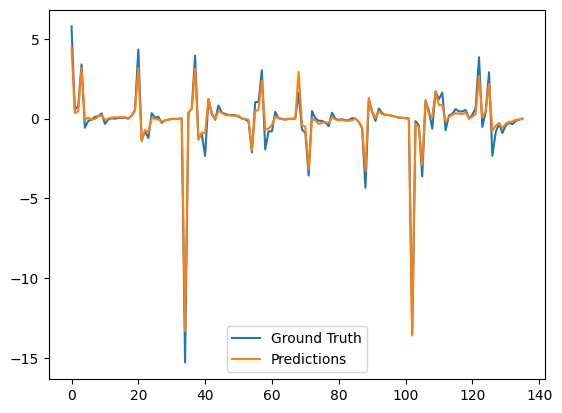

In [48]:
# Create a test dataset and DataLoader
test_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)  # Batch size of 5
norm_consts = np.load(rf"gait reference fft5.00/newnormalization_constants.npy")
# Testing loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
test_loss = 0.0

k = 0
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_dataloader:
        speed = inputs[0,0].item()*3
        targets = targets.reshape(-1,136)
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_fn(outputs, targets)
        test_loss += loss.item()
        ground_truth = targets.reshape(-1,4,2,17)
        predictions = outputs.reshape(-1,4,2,17)

        predictions = predictions.detach().numpy()
        predictions = predictions[0]
        ground_truth = ground_truth.detach().numpy()
        ground_truth = ground_truth[0]

        predictions, ground_truth = denormalize(predictions,ground_truth,norm_consts)
        pred_time,gt_time = pred_ifft(predictions,ground_truth,speed,norm_consts)
        # animate_biped(pred_time,f"predict_plots_25hs512_fft/{speed:.1f}ms.gif")
        # animate_biped(gt_time,f"predict_plots_25hs512_fft/{speed:.1f}ms.gif")
        k+=1
# Calculate average loss and accuracy
test_loss /= len(test_dataloader)  # Average test loss


# Print test results
print(f"Test Loss: {test_loss:.4f}")
plt.plot(targets[0].numpy())
plt.plot(outputs[0].numpy())
plt.legend(['Ground Truth', 'Predictions'])